In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import cv2
import PIL

# import ML/DL libraries
from sklearn.model_selection import train_test_split
from sklearn import utils # used to shuffle data

from keras.preprocessing.image import ImageDataGenerator # used for image augmentation


import tensorflow as tf
# used for building and training a new model
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16

# import functions from other python files
from code_files.imagePreprocessing import * 
from code_files.plottingFunctions import *

c:\Users\Rebecca\anaconda3\envs\MLEnv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# disabling the GPU allows the model here to run
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 

In [3]:
# preprocess data 
dfTrain, dfVal, dfTest = importSetImages('datasets/spiral_data')
train_imgNames, trainLbl, val_imgNames, valLbl, test_imgNames, testLbl = dfTrain['images'], dfTrain['label'], dfVal['images'], dfVal['label'], dfTest['images'], dfTest['label']

In [4]:
# function to imgAug preprocessing, need to get data in desired form
def imgAug_preprocessing(train_feature, val_feature, test_feature):
    # for each of the data sets (train, val, and test), convert from rgb to grayscale
    # then convert to an array of pixels [0-255] --> this returns an array of size (256,256,1)
    # resize to (128x128) for faster image processing and a more efficient model, data doesn't get lost in this resize
    # need to account for the batch dimension (used in tensorflow), so expand dim to shape (1,128,128,1)
    def img2array(dataset):
        storage_array = []
        for img_path in dataset:
            image = cv2.imread(img_path)
            # imgArray = np.expand_dims(imgArray, axis=0) # if keeping rgb, use axis=0

            # store in array
            storage_array.append(image)
        
        return storage_array

    train_array = img2array(train_feature)
    val_array   = img2array(val_feature)
    test_array  = img2array(test_feature)

    return train_array, val_array, test_array

In [5]:
train, val, test = imgAug_preprocessing(train_imgNames, val_imgNames, test_imgNames)

In [6]:
# convert labels to categorical for training model
trainLblAug = tf.keras.utils.to_categorical(np.array(trainLbl))
valLblAug = tf.keras.utils.to_categorical(np.array(valLbl))

In [21]:
base = VGG16(weights='imagenet', include_top=False,input_shape=(128,128,3))

base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [1]:
# extract features

def extract_features(imgs, num_imgs):
    datagen = ImageDataGenerator(rescale=1./255)
    batch_size = 11
    
    features = np.zeros(shape=(num_imgs, 4,4,512)) # shape equal to output of convolutional base
    lbls = np.zeros(shape=(num_imgs,))

    # preprocess data
    generator = datagen.flow_from_directory(imgs, target_size=(128,128), class_mode='categorical', batch_size=batch_size)

    print('pause')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        lbls[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= num_imgs:
            break
    return features, lbls

In [2]:
train_feat, train_lbls = extract_features('datasets/spiral_data/train', 71)
val_feat, val_lbls = extract_features('datasets/spiral_data/val', 15)
# test_feat, test_lbls = extract_features('datasets/spiral_data/test', 16)

NameError: name 'ImageDataGenerator' is not defined

In [153]:
epochs = 100

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(4,4,512)))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_27  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_27 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_________________________________________________________________


In [137]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)  # use the Adam optimizer and set an effective learning rate 
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

trained_model = model.fit(train_feat, train_lbls, batch_size=batch_size, epochs=epochs, validation_data=(val_feat, val_lbls))

Epoch 1/100
12/12 [==============================] - 1s 19ms/step - loss: 0.7494 - accuracy: 0.4930 - val_loss: 0.7184 - val_accuracy: 0.5333
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 0.7416 - accuracy: 0.4930 - val_loss: 0.7118 - val_accuracy: 0.5333
Epoch 3/100
12/12 [==============================] - 0s 5ms/step - loss: 0.7312 - accuracy: 0.4930 - val_loss: 0.7075 - val_accuracy: 0.5333
Epoch 4/100
12/12 [==============================] - 0s 5ms/step - loss: 0.7247 - accuracy: 0.4930 - val_loss: 0.7035 - val_accuracy: 0.5333
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7190 - accuracy: 0.4930 - val_loss: 0.6999 - val_accuracy: 0.5333
Epoch 6/100
12/12 [==============================] - 0s 5ms/step - loss: 0.7154 - accuracy: 0.4930 - val_loss: 0.6968 - val_accuracy: 0.5333
Epoch 7/100
12/12 [==============================] - 0s 5ms/step - loss: 0.7097 - accuracy: 0.5211 - val_loss: 0.6939 - val_accuracy: 0.6000
Epoch 8/100


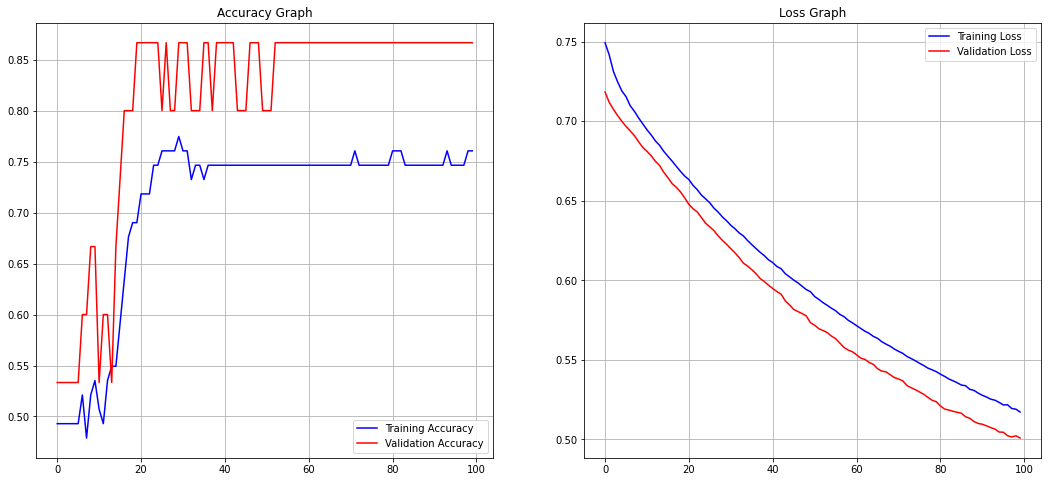

In [154]:
# -------------------------------------
# plot and save the results
# Accuracy and Validation Accuracy
accuracy1 = trained_model.history['accuracy']
val_acc1 = trained_model.history['val_accuracy']
epochs = range(len(accuracy1))

fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,8)
ax[0].plot(epochs, accuracy1, 'b', label='Training Accuracy')
ax[0].plot(epochs, val_acc1, 'r', label='Validation Accuracy')
ax[0].title.set_text('Accuracy Graph')
ax[0].legend()
ax[0].grid()

# Loss and Validation Loss
loss1 = trained_model.history['loss']
val_loss1 = trained_model.history['val_loss']

ax[1].plot(epochs, loss1, 'b', label='Training Loss')
ax[1].plot(epochs, val_loss1, 'r', label='Validation Loss')
ax[1].title.set_text('Loss Graph')
ax[1].legend()
ax[1].grid()

In [ ]:
modelName ='20221004'

# save model
savenameh5 = modelName + '.h5'
savenametf = modelName + '.tf'
model.save(savenameh5)
model.save(savenametf)

In [140]:
# ---------------------------------------------------------------------------------------
#                             LOAD PRE-EXISTING MODEL MODEL
# ---------------------------------------------------------------------------------------
def importModel(filename, testAug, testAugLabel):
    modelPath = 'savedModels/saved_h5_models/' + filename
    testModel = tf.keras.models.load_model(modelPath)

    loss, acc = testModel.evaluate(np.array(testAug), testAugLabel, verbose=2)
    print("Loss: ", loss, "| Accuracy: ", acc)

    return testModel

In [144]:
# load existing model and evaluate the test data

# covert label array to binary class matrix (healthy, PD)
# testLbl_categorical = tf.keras.utils.to_categorical(np.array(testLbl))
# test, testLbl = utils.shuffle(test, testLbl)
model = importModel('20221004.h5', test_feat, test_lbls)

1/1 - 0s - loss: 0.4936 - accuracy: 0.8750 - 216ms/epoch - 216ms/step
Loss:  0.49364185333251953 | Accuracy:  0.875


In [ ]:
# plot the results
misClass_test, misClass_idx = plotImages(model, test, testLbl)
print(np.shape(misClass_test))
print(misClass_idx)